# Implementation of Gamma Surface calculation 
The Gamma Surface calculation requires multiple calculations, therefore we use the ParallelMaster Class and implement a ParallelMaster for Gamma Surface calculations.

In [1]:
import numpy as np
import matplotlib.pylab as plt

In [2]:
from pyiron import Project

# Class templates 
We import two additional classes the AtomisticParallelMaster and the JobGenerator

In [3]:
from pyiron.atomistics.master.parallel import AtomisticParallelMaster
from pyiron.base.master.parallel import JobGenerator

## JobGenerator
The JobGenerator has three primary functions:
* `parameter_list()` which generates a list of parameters, each parameter can then be executed in parallel. 
* `job_name()` a function to rename the temlate job using one parameter out of the parameter list. 
* `modify_job()` the function which modifies the job based on one parameter out of the parameter list. 
Finally there is one additional function to construct the structures the `get_structure()` function. 

In [4]:
class GammaJobGenerator(JobGenerator):
    @property
    def parameter_list(self):
        """

        Returns:
            (list)
        """
        parameter_lst = []
        structure = self._job.ref_job.structure
        x_max = structure.cell[0, 0]
        y_max = structure.cell[1, 1]
        x_vec = np.linspace(0, x_max, self._job.input["n_mesh_x"])
        y_vec = np.linspace(0, y_max, self._job.input["n_mesh_y"])
        for x in x_vec:
            for y in y_vec:
                parameter_lst.append([structure.copy(), x,y])
        return parameter_lst

    @staticmethod
    def job_name(parameter):
        return 'x_{:.4}_y_{:.4}'.format(parameter[1], parameter[2]).replace('.', '_')

    def modify_job(self, job, parameter):
        job.structure = self.get_structure(structure=parameter[0], x=parameter[1], y=parameter[2])
        return job
    
    @staticmethod
    def get_structure(structure, x, y):
        z = structure.positions[:, 2]
        z_0 = np.mean(z)
        structure.positions[z < z_0, 0] += x
        structure.positions[z < z_0, 1] += y
        structure.add_tag(selective_dynamics=[False, False, True])
        structure.pbc[2] = True
        return structure

## ParallelMaster
The ParallelMaster includes the JobGenerator as an object and in addition adds auxiliary functions to simplify the interaction of the user with the class. In this case these are the `collect_output()` function which summarizes the results of the individual collection as well as two plot functions the regular `plot()` function and the `plot2d()` function to visualise the results. In general the ParallelMaster primarly implements the functionality to aggregate the data once the calculation is finished. 

In [5]:
class GammaSurface(AtomisticParallelMaster):
    def __init__(self, project, job_name):
        super(GammaSurface, self).__init__(project, job_name)
        self.__name__ = "GammaSurface"
        self.__version__ = "0.0.1"
        self.input["n_mesh_x"] = 10
        self.input["n_mesh_y"] = 10
        self._job_generator = GammaJobGenerator(self)
        self._output = {}
    
    def collect_output(self):
        if self.server.run_mode.interactive:
            ham = self.project_hdf5.inspect(self.child_ids[0])
            self._job_generator.parameter_list
            erg_lst = ham["output/generic/energy_tot"]
            _, x_lst, y_lst = zip(*self._job_generator.parameter_list)
        else:
            erg_lst, x_lst, y_lst = [], [], []
            for job_id in self.child_ids:
                ham = self.project_hdf5.inspect(job_id)
                erg_lst.append(ham["output/generic/energy_tot"][-1])
                job_name = ham.job_name
                x_lst.append(float(job_name.split("_y_")[0].split("x_")[1].replace('_', '.')))
                y_lst.append(float(job_name.split("_y_")[1].replace('_', '.')))
        self._output["energy"] = erg_lst
        self._output["x"] = x_lst
        self._output["y"] = y_lst
        with self.project_hdf5.open("output") as hdf5_out:
            for key, val in self._output.items():
                hdf5_out[key] = val
                
    def plot(self):
        if len(self._output) > 0:
            plt.plot(self._output["y"], self._output["energy"], 'x-'); 
        
    def plot2d(self):
        plt.imshow(np.reshape(self._output["energy"], (self.input["n_mesh"][0],-1)))

# Example Project
To demonstrate the useage of the newly implemented class we create a small example project. 

In [6]:
pr = Project("Gamma_parallel")

In [7]:
pr.remove_jobs_silently(recursive=True)

## Execution 
We use interactive LAMMPS jobs and calculate the gamma surface for two fcc crystal orientations namely 111 and 100. 

The job gamma_fcc111 was saved and received the ID: 1
The job gamma_fcc111_ref_job was saved and received the ID: 2
The job gamma_fcc100 was saved and received the ID: 3
The job gamma_fcc100_ref_job was saved and received the ID: 4


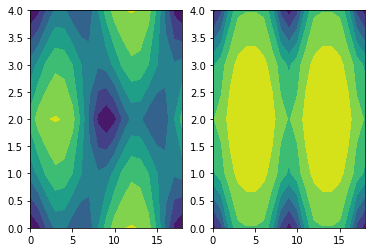

In [8]:
surface_list = ['fcc111', 'fcc100']
fig, ax_list = plt.subplots(ncols=2, nrows=1, sharex=True)

potential = 'Al_Mg_Mendelev_eam'
for i, surf in enumerate(surface_list):
    with pr.open(surf) as pr_test:
        ax= ax_list[i]
        Al = pr_test.create_surface('Al', surf, (1,2,12), vacuum=10, orthogonal=True)
        ref_job = pr_test.create_job(pr_test.job_type.Lammps, 'ref_job')
        ref_job.structure = Al
        ref_job.potential = potential
        ref_job.calc_minimize()
        ref_job.interactive_enforce_structure_reset = True
        ref_job.server.run_mode.interactive = True
        gs = ref_job.create_job(GammaSurface, "gamma_" + surf)
        gs.input["n_mesh_x"] = 5
        gs.input["n_mesh_y"] = 19
        gs.run()
        ax.contourf(np.reshape(gs._output["energy"], (gs.input["n_mesh_x"],-1)))